AdaBoost 70/30


In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import time
import matplotlib.pyplot as plt


In [36]:
file_path = '../Data/EURUSD.xlsx'  
try:
    data = pd.read_excel(file_path)
    print(f"File '{file_path}' berhasil dimuat. Jumlah baris awal: {len(data)}")
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data.set_index('Date', inplace=True)
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan.")
    raise
data.head()

File '../Data/EURUSD.xlsx' berhasil dimuat. Jumlah baris awal: 1001


,Close
Date,
2022-05-15,1.03980
2022-05-16,1.04390
2022-05-17,1.05487
2022-05-18,1.04729
2022-05-19,1.05795


In [37]:
data['Close_Before_H-1'] = data['Close'].shift(1)
data['Close_Before_H-2'] = data['Close'].shift(2)
data['Close_Before_H-3'] = data['Close'].shift(3)

data.dropna(inplace=True)
print(f"Data setelah feature engineering dan pembersihan. Jumlah baris: {len(data)}")
data.head()

Data setelah feature engineering dan pembersihan. Jumlah baris: 998


,Close,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3
Date,,,,
2022-05-18,1.04729,1.05487,1.04390,1.03980
2022-05-19,1.05795,1.04729,1.05487,1.04390
2022-05-20,1.05610,1.05795,1.04729,1.05487
2022-05-22,1.05689,1.05610,1.05795,1.04729
2022-05-23,1.06837,1.05689,1.05610,1.05795


In [38]:
data.shape  
data.isna().sum()

Close               0
Close_Before_H-1    0
Close_Before_H-2    0
Close_Before_H-3    0
dtype: int64

In [39]:
X = data[['Close_Before_H-1', 'Close_Before_H-2', 'Close_Before_H-3']]
y = data['Close']
train_size_70 = int(len(X) * 0.7)

X_train_70, X_test_70 = X[:train_size_70], X[train_size_70:]
y_train_70, y_test_70 = y[:train_size_70], y[train_size_70:]
print(f"Pembagian data 70/30: {len(X_train_70)} latih / {len(X_test_70)} uji")

Pembagian data 70/30: 698 latih / 300 uji


In [40]:
print("\nMemulai pelatihan model Gradient Boosting")
ada = AdaBoostRegressor(random_state=42) 
start_time = time.time()
ada.fit(X_train_70, y_train_70)
training_time = time.time() - start_time

# Detail proses pelatihan:
print("\nDetail proses pelatihan:")
print(f"Jumlah data latih: {len(X_train_70)}")
print(f"Jumlah fitur: {X_train_70.shape[1]}")
print("Fitur penting:", ada.feature_importances_)
print(f"Pelatihan Gradient Boosting selesai dalam {training_time:.4f} detik.")



Memulai pelatihan model Gradient Boosting

Detail proses pelatihan:
Jumlah data latih: 698
Jumlah fitur: 3
Fitur penting: [0.85435846 0.04825057 0.09739096]
Pelatihan Gradient Boosting selesai dalam 0.0855 detik.


In [41]:
# Melakukan prediksi pada data uji dengan model AdaBoost
y_pred_70 = ada.predict(X_test_70)
print("Hasil prediksi (5 data pertama):", y_pred_70[:5])
print("Nilai aktual (5 data pertama):", y_test_70.values[:5])

data_metrics = pd.DataFrame({
    'R2 Score': [r2_score(y_test_70, y_pred_70)],
    'MSE': [mean_squared_error(y_test_70, y_pred_70)],
    'MAE': [mean_absolute_error(y_test_70, y_pred_70)],
    'MAPE': [mean_absolute_percentage_error(y_test_70, y_pred_70)],
    'Waktu Pelatihan (detik)': [training_time]
})

hasil_prediksi_data = X_test_70.copy()
hasil_prediksi_data['Hasil Prediksi'] = y_pred_70
hasil_prediksi_data['Aktual'] = y_test_70.values

# Menampilkan kedua tabel
display(data_metrics)
display(hasil_prediksi_data.head())

Hasil prediksi (5 data pertama): [1.09270882 1.09196561 1.09270882 1.09638708 1.09759957]
Nilai aktual (5 data pertama): [1.09127 1.09361 1.09959 1.10116 1.09723]


,R2 Score,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,0.730958,0.000509,0.013873,0.012214,0.085451


,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3,Hasil Prediksi,Aktual
Date,,,,,
2024-08-11,1.09167,1.09149,1.09273,1.092709,1.09127
2024-08-12,1.09127,1.09167,1.09149,1.091966,1.09361
2024-08-13,1.09361,1.09127,1.09167,1.092709,1.09959
2024-08-14,1.09959,1.09361,1.09127,1.096387,1.10116
2024-08-15,1.10116,1.09959,1.09361,1.097600,1.09723


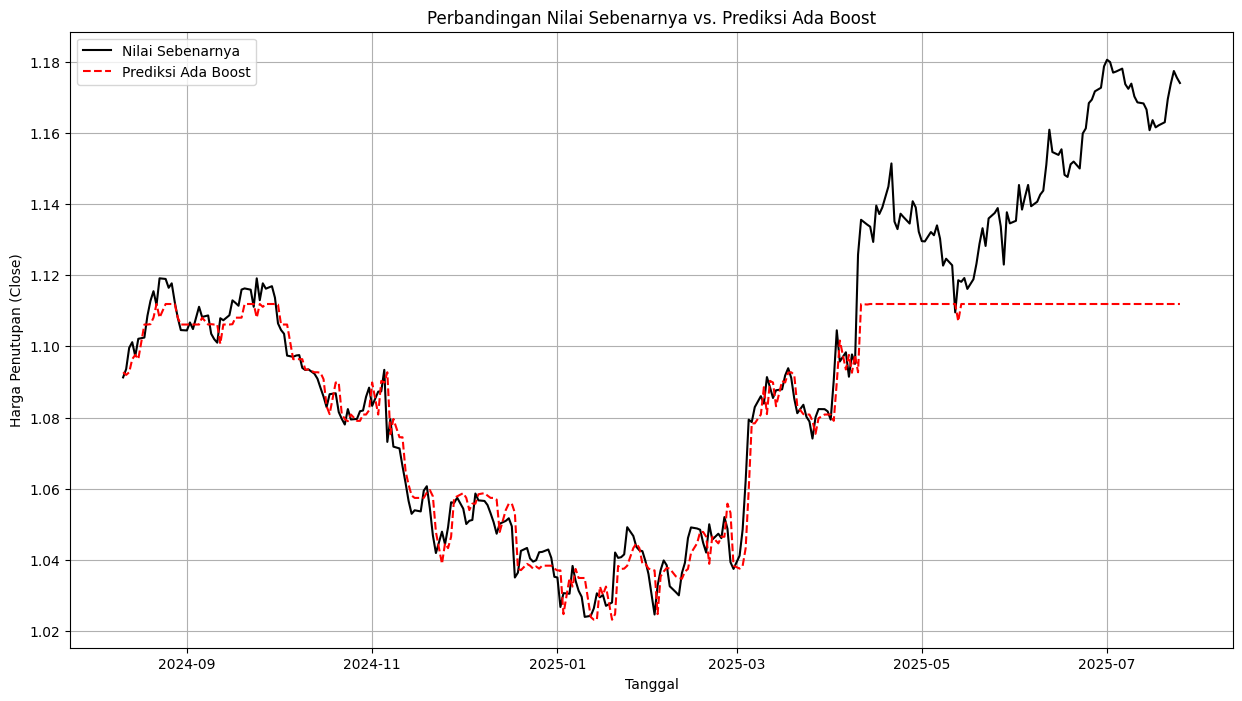

In [42]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_70.index, y_test_70.values, label='Nilai Sebenarnya', color='black')
plt.plot(y_test_70.index, y_pred_70, label='Prediksi Ada Boost', color='red', linestyle='--')
plt.title('Perbandingan Nilai Sebenarnya vs. Prediksi Ada Boost')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid(True)
plt.show()


Ada Boost 80/20

In [43]:
train_size_80 = int(len(X) * 0.8)

X_train_80, X_test_80 = X[:train_size_80], X[train_size_80:]
y_train_80, y_test_80 = y[:train_size_80], y[train_size_80:]
print(f"Pembagian data 80/20: {len(X_train_80)} latih / {len(X_test_80)} uji")


Pembagian data 80/20: 798 latih / 200 uji


In [44]:
print("\nMemulai pelatihan model Gradient Boosting")
reg = AdaBoostRegressor (random_state=42)  
start_time = time.time()  
reg.fit(X_train_80, y_train_80)  
training_time = time.time() - start_time  

# Detail proses pelatihan:
print("\nDetail proses pelatihan:")
print(f"Jumlah data latih: {len(X_train_80)}")
print(f"Jumlah fitur: {X_train_80.shape[1]}")
print("Feature Importances:", reg.feature_importances_)
print(f"Pelatihan Gradient Boosting selesai dalam {training_time:.4f} detik.")



Memulai pelatihan model Gradient Boosting

Detail proses pelatihan:
Jumlah data latih: 798
Jumlah fitur: 3
Feature Importances: [0.78047358 0.15383147 0.06569496]
Pelatihan Gradient Boosting selesai dalam 0.0555 detik.


In [45]:
y_pred_80 = reg.predict(X_test_80)

print("Hasil prediksi (5 data pertama):", y_pred_80[:5])
print("Nilai aktual (5 data pertama):", y_test_80.values[:5])

data_metrics_80 = pd.DataFrame({
    'R2 Score': [r2_score(y_test_80, y_pred_80)],
    'MSE': [mean_squared_error(y_test_80, y_pred_80)],
    'MAE': [mean_absolute_error(y_test_80, y_pred_80)],
    'MAPE': [mean_absolute_percentage_error(y_test_80, y_pred_80)],
    'Waktu Pelatihan (detik)': [training_time]
})

hasil_prediksi_data_80 = X_test_80.copy()
hasil_prediksi_data_80['Hasil Prediksi'] = y_pred_80
hasil_prediksi_data_80['Aktual'] = y_test_80.values

# Menampilkan kedua tabel
display(data_metrics_80)
display(hasil_prediksi_data_80.head())


Hasil prediksi (5 data pertama): [1.05589205 1.05895221 1.05771225 1.05681286 1.05681286]
Nilai aktual (5 data pertama): [1.05865 1.05673 1.05656 1.05541 1.05311]


,R2 Score,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,0.696697,0.000781,0.01944,0.017055,0.055545


,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3,Hasil Prediksi,Aktual
Date,,,,,
2024-12-05,1.05123,1.05099,1.05008,1.055892,1.05865
2024-12-06,1.05865,1.05123,1.05099,1.058952,1.05673
2024-12-08,1.05673,1.05865,1.05123,1.057712,1.05656
2024-12-09,1.05656,1.05673,1.05865,1.056813,1.05541
2024-12-10,1.05541,1.05656,1.05673,1.056813,1.05311


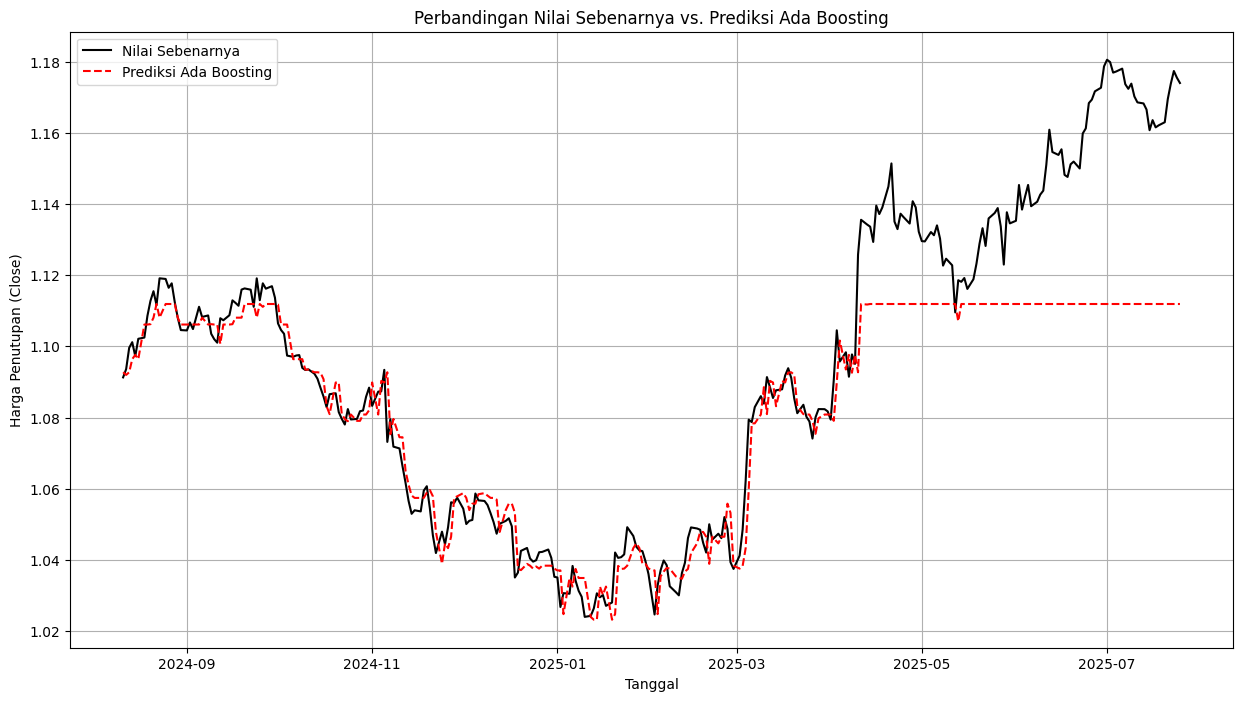

In [46]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_70.index, y_test_70.values, label='Nilai Sebenarnya', color='black')
plt.plot(y_test_70.index, y_pred_70, label='Prediksi Ada Boosting', color='red', linestyle='--')
plt.title('Perbandingan Nilai Sebenarnya vs. Prediksi Ada Boosting')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
#Melakukan prediksi pada data uji 80/20
comparison_data = pd.DataFrame({
    'Split': ['70/30', '80/20'],
    'R2 Score': [data_metrics['R2 Score'][0], data_metrics_80['R2 Score'][0]],
    'MSE': [data_metrics['MSE'][0], data_metrics_80['MSE'][0]],
    'MAE': [data_metrics['MAE'][0], data_metrics_80['MAE'][0]],
    'MAPE': [data_metrics['MAPE'][0], data_metrics_80['MAPE'][0]],
    'Waktu Pelatihan (detik)': [data_metrics['Waktu Pelatihan (detik)'][0], data_metrics_80['Waktu Pelatihan (detik)'][0]]
})

display(comparison_data)

#Menampilkan split dengan akurasi (R2 Score) tertinggi
best_split = comparison_data.loc[comparison_data['R2 Score'].idxmax()]
print(f"Split dengan akurasi (R2 Score) tertinggi: {best_split['Split']} (R2 Score: {best_split['R2 Score']:.5f})")

,Split,R2 Score,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,70/30,0.730958,0.000509,0.013873,0.012214,0.085451
1,80/20,0.696697,0.000781,0.019440,0.017055,0.055545


Split dengan akurasi (R2 Score) tertinggi: 70/30 (R2 Score: 0.73096)
